In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,21.844,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,15.814,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,16.067,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,14.938,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,17.765,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


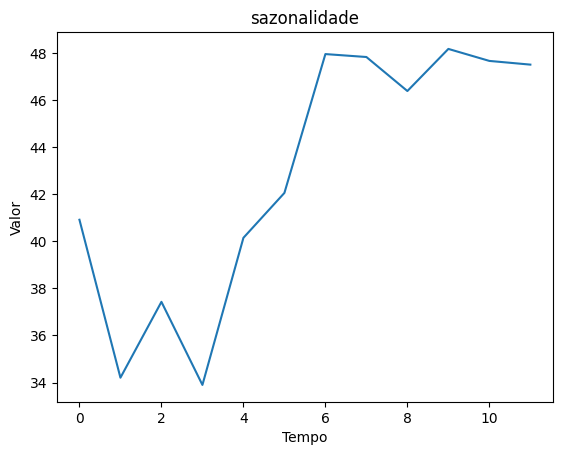

,sazonalidade
sazonalidade,
0,40.916431
1,34.205392
2,37.428614
3,33.898400
4,40.148665
5,42.056820
6,47.956359
7,47.831761
8,46.386295


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,40.916431,21.844
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,34.205392,15.814
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,37.428614,16.067
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,33.898400,14.938
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,40.148665,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.148665,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.056820,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.956359,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.831761,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Piauí - Consumo de Cimento (t), Length: 249, dtype: float64

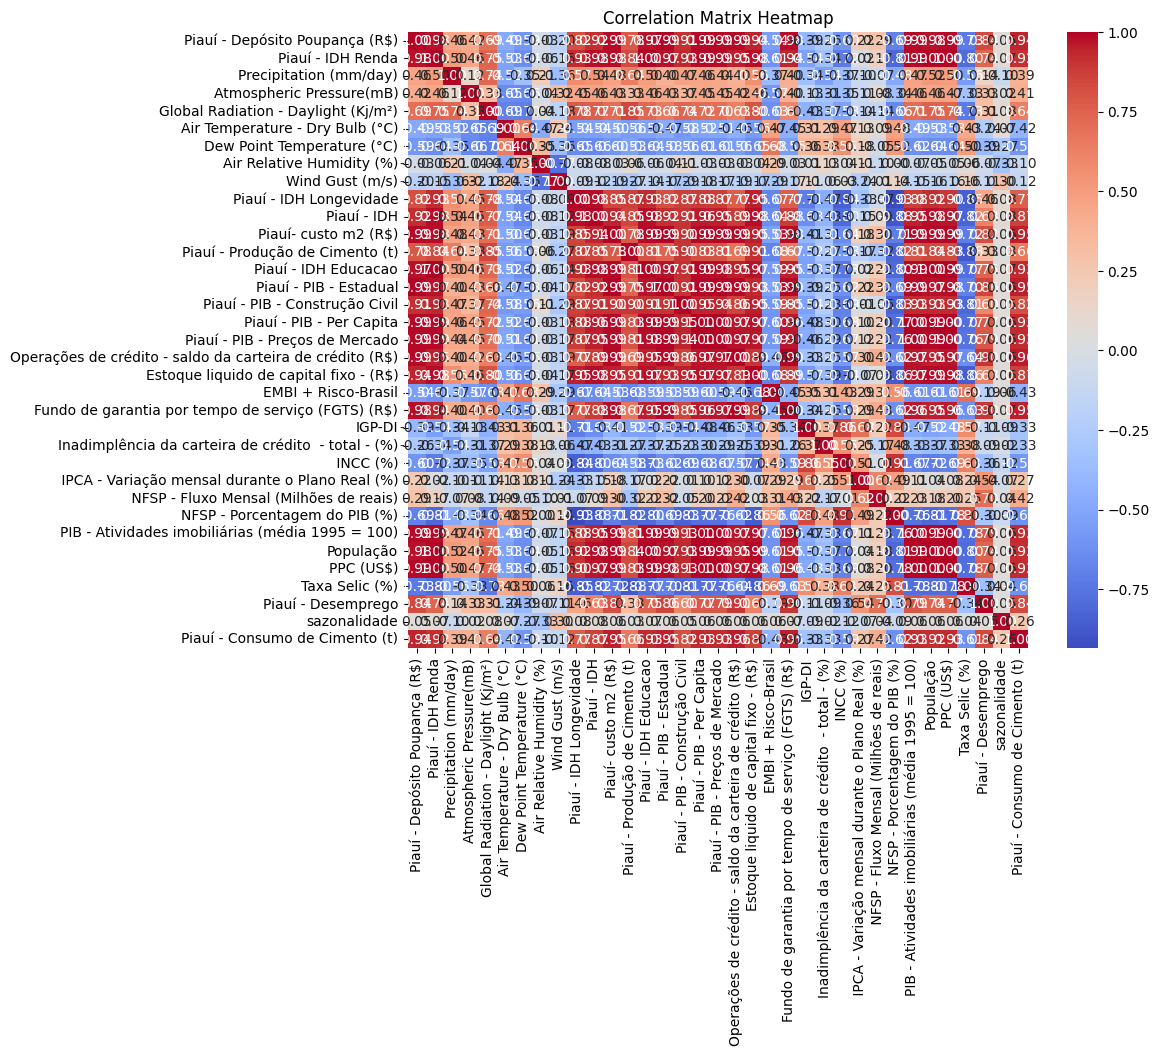

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Piauí - Depósito Poupança (R$),1.315234e+06
1,Piauí - IDH Renda,1.059044e+09
2,Precipitation (mm/day),4.709607e+01
3,Atmospheric Pressure(mB),1.300792e+07
4,Global Radiation - Daylight (Kj/m²),1.596069e+02
5,Air Temperature - Dry Bulb (°C),6.425143e+04
6,Dew Point Temperature (°C),1.894975e+04
7,Air Relative Humidity (%),1.515544e+04
8,Wind Gust (m/s),5.218368e+02
9,Piauí - IDH Longevidade,1.477775e+10


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)',
                 'Inadimplência da carteira de crédito  - total - (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,1.392136e+06,0.578335,0.572145,619.438209,29.774322,22.498674,65.288728,1.531145,9410.948400,24.669760,2.136063e+07,1.358044e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,8.192266,40.916431
1,1.402507e+06,0.578959,0.575756,621.987667,29.768728,22.492857,65.296204,1.530215,9501.490708,25.167145,2.139102e+07,1.359835e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,8.186156,34.205392
2,1.412879e+06,0.579583,0.577863,623.474852,29.765464,22.489463,65.300565,1.529673,9582.303300,25.520404,2.142142e+07,1.361626e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,8.180046,37.428614
3,1.423251e+06,0.580207,0.578089,623.634193,29.765115,22.489100,65.301032,1.529614,9659.062943,25.519725,2.145181e+07,1.363417e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,8.173937,33.898400
4,1.433623e+06,0.580831,0.565428,593.257336,29.985428,22.815550,65.747286,1.500524,9730.815357,25.929312,2.148221e+07,1.365208e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,8.167827,40.148665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,3.586822e+06,0.644730,1.059068,1326.635155,28.779101,18.358041,58.606146,1.367439,21460.751647,39.817022,2.636308e+07,1.437619e+06,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,11.104472,47.831761
152,3.584765e+06,0.645973,0.884877,1348.744016,29.443637,18.176940,55.868885,1.510911,21556.142265,39.141673,2.638108e+07,1.436785e+06,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,11.124340,46.386295
153,3.582708e+06,0.647217,0.965906,1301.987967,29.439595,18.609750,57.234677,1.528948,21650.883776,38.466061,2.639908e+07,1.435951e+06,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,11.144207,48.175386
154,3.580651e+06,0.648461,1.141109,1274.503986,29.186111,19.304875,60.202811,1.484069,21745.563315,37.762130,2.641708e+07,1.435117e+06,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,11.164074,47.665609


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,-1.979411,-0.655746,-0.772881,0.286985,0.202699,-0.261752,0.926296,-1.558980,-1.859538,-1.547081,-2.211572,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617,-0.516521
1,-1.947037,-0.652104,-0.768322,0.284764,0.200578,-0.260954,0.922604,-1.534748,-1.802161,-1.528063,-2.149617,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013,-0.521964
2,-1.914663,-0.649980,-0.765663,0.283468,0.199341,-0.260489,0.920451,-1.513120,-1.761409,-1.509045,-2.087663,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457,-0.527406
3,-1.882289,-0.649752,-0.765378,0.283329,0.199209,-0.260439,0.920220,-1.492577,-1.761488,-1.490027,-2.025708,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128,-0.532849
4,-1.849915,-0.662520,-0.819691,0.370827,0.318229,-0.212847,0.804734,-1.473373,-1.714239,-1.471009,-1.963754,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025,-0.538292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.465130,-0.164689,0.491550,-0.108271,-1.306929,-0.974445,0.276404,1.665947,-0.112187,1.583078,0.541345,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123,2.077729
152,1.529652,-0.340359,0.531079,0.155653,-1.372956,-1.266372,0.845971,1.691476,-0.190093,1.594341,0.512491,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135,2.095427
153,1.594174,-0.258643,0.447482,0.154047,-1.215159,-1.120711,0.917572,1.716832,-0.268030,1.605605,0.483637,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308,2.113125
154,1.658696,-0.081952,0.398342,0.053375,-0.961724,-0.804162,0.739409,1.742172,-0.349234,1.616869,0.454783,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029,2.130823


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,-1.979411,-0.655746,-0.772881,0.286985,0.202699,-0.261752,0.926296,-1.558980,-1.859538,-1.547081,-2.211572,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617,-0.516521
1,-1.947037,-0.652104,-0.768322,0.284764,0.200578,-0.260954,0.922604,-1.534748,-1.802161,-1.528063,-2.149617,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013,-0.521964
2,-1.914663,-0.649980,-0.765663,0.283468,0.199341,-0.260489,0.920451,-1.513120,-1.761409,-1.509045,-2.087663,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457,-0.527406
3,-1.882289,-0.649752,-0.765378,0.283329,0.199209,-0.260439,0.920220,-1.492577,-1.761488,-1.490027,-2.025708,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128,-0.532849
4,-1.849915,-0.662520,-0.819691,0.370827,0.318229,-0.212847,0.804734,-1.473373,-1.714239,-1.471009,-1.963754,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025,-0.538292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.063322,-0.037914,0.927918,-0.135374,-1.133913,-0.896087,0.810292,1.370833,0.393131,1.435888,0.964879,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621,1.784416
140,1.053353,0.256435,0.893647,0.026050,-1.116985,-1.051226,1.106541,1.394455,0.366670,1.449557,0.920568,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121,1.818301
141,1.043384,0.202246,0.788523,0.029749,-1.018875,-0.986337,1.175837,1.417856,0.340298,1.463226,0.876257,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902,1.852186
142,1.033415,0.468871,0.579761,-0.102054,-0.844589,-0.684349,0.637042,1.441573,0.314115,1.476895,0.831945,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143,1.886071


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.758000
1      19.763000
2      22.445000
3      20.109000
4      24.283000
         ...    
139    83.674054
140    81.448833
141    83.156877
142    82.177717
143    74.064500
Name: Piauí - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Piauí - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Piauí - Desemprego
108,0.744504,0.539495,0.629731,-0.733238,0.029601,0.774372,-0.490727,0.697872,1.321814,0.744786,1.001600,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183,0.290917
109,0.775781,0.698619,0.687885,-0.799502,0.066392,0.899229,-0.887117,0.719962,1.289945,0.771079,1.016401,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767,0.348534
110,0.807057,0.189817,0.727363,-0.787992,0.040523,0.874950,-1.103693,0.739515,1.284703,0.797371,1.031202,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482,0.406151
111,0.838333,-0.181286,0.767388,-0.745724,-0.168657,0.629414,-1.170964,0.759025,1.258486,0.823663,1.046003,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413,0.463768
112,0.869609,-0.516964,0.865218,-0.640220,-0.597064,0.105353,-0.873733,0.778382,1.293430,0.849956,1.060804,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135,0.521385
113,0.900885,-0.777061,0.953664,-0.485771,-0.992530,-0.410358,-0.561260,0.798000,1.252034,0.876248,1.075605,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280,0.579003
114,0.932161,-0.915186,1.071260,-0.238632,-1.320546,-0.934128,-0.094033,0.816561,1.243145,0.902540,1.090406,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452,0.636620
115,0.963437,-0.829857,1.111381,-0.011370,-1.445311,-1.259133,0.388599,0.834649,1.206561,0.928833,1.105207,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037,0.694237
116,0.994713,-0.478631,1.077016,0.094713,-1.260176,-1.184579,0.446018,0.852516,1.175704,0.955125,1.120008,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721,0.751854
117,1.025989,-0.006967,0.978807,0.020840,-0.995458,-0.875803,0.723850,0.870937,1.140084,0.981417,1.134809,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995,0.809471


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[84533745, 2664183652, 1936670275, 1898330076, 767184529, 816802554, 324370173, 1851640116, 3786471179, 4073240838]


Step: 0 ___________________________________________
val_loss: 13.147377967834473
winner_seed: 84533745


Step: 1 ___________________________________________
val_loss: 12.900860786437988
winner_seed: 2664183652


Step: 2 ___________________________________________
val_loss: 10.071428298950195
winner_seed: 1936670275


Step: 3 ___________________________________________
val_loss: 16.961605072021484


Step: 4 ___________________________________________
val_loss: 13.539012908935547


Step: 5 ___________________________________________
val_loss: 15.458130836486816


Step: 6 ___________________________________________
val_loss: 18.90882682800293


Step: 7 ___________________________________________
val_loss: 26.989397048950195


Step: 8 ___________________________________________
val_loss: 20.745254516601562


Step: 9 ___________________________________________
val_loss: 25.4

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3430781553

Epoch 1/10000
4/4 [==============================] - 2s 261ms/step - loss: 3454.0486 - val_loss: 2527.9390
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 852.3624 - val_loss: 619.7307
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 282.3823 - val_loss: 1145.3857
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 527.4355 - val_loss: 488.5643
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 215.4094 - val_loss: 92.1009
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 169.7989 - val_loss: 492.9144
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 208.2068 - val_loss: 252.4132
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 163.6540 - val_loss: 155.0047
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 133.8799 - val_loss: 164.1782
Epoch 10/10000
4/4 [==============================] - 0s 7ms/step - l

4/4 [==============================] - 0s 7ms/step - loss: 45.2841 - val_loss: 48.8119
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 123.7928 - val_loss: 118.6395
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.0821 - val_loss: 152.3780
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.6598 - val_loss: 133.2168
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.6703 - val_loss: 145.4792
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 42.3536 - val_loss: 73.6967
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 77.2662 - val_loss: 173.6745
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.0862 - val_loss: 112.1757
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 46.1808 - val_loss: 156.0820
Epoch 89/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.0802 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 25.5735 - val_loss: 182.6604
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.1044 - val_loss: 172.8562
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.7987 - val_loss: 135.3254
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.4996 - val_loss: 144.3477
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.0957 - val_loss: 125.9021
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.4077 - val_loss: 120.9176
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.3422 - val_loss: 142.5490
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.7286 - val_loss: 158.7186
Epoch 167/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.3295 - val_loss: 110.3261
Epoch 168/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.48

4/4 [==============================] - 0s 7ms/step - loss: 54.4765 - val_loss: 28.2533
Epoch 239/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.1641 - val_loss: 34.4539
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.6245 - val_loss: 48.0974
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.2707 - val_loss: 31.9919
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.7806 - val_loss: 22.3314
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - loss: 80.5406 - val_loss: 21.2727
Epoch 244/10000
4/4 [==============================] - 0s 7ms/step - loss: 50.6247 - val_loss: 44.0155
Epoch 245/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.6951 - val_loss: 64.1737
Epoch 246/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.5294 - val_loss: 72.2704
Epoch 247/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.0002 - val_

4/4 [==============================] - 0s 7ms/step - loss: 28.8874 - val_loss: 46.4903
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.3514 - val_loss: 60.7466
Epoch 319/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.9041 - val_loss: 108.7025
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.1417 - val_loss: 60.7532
Epoch 321/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.2511 - val_loss: 33.1504
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.1520 - val_loss: 52.7391
Epoch 323/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.3934 - val_loss: 49.4072
Epoch 324/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.7760 - val_loss: 47.9170
Epoch 325/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.4847 - val_loss: 21.6091
Epoch 326/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.3807 - val

4/4 [==============================] - 0s 7ms/step - loss: 17.2231 - val_loss: 41.7427
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.1683 - val_loss: 39.7568
Epoch 398/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.4844 - val_loss: 49.7806
Epoch 399/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.2319 - val_loss: 64.0785
Epoch 400/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.5278 - val_loss: 43.8160
Epoch 401/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.0626 - val_loss: 44.3232
Epoch 402/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.5931 - val_loss: 21.4002
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.7748 - val_loss: 36.2720
Epoch 404/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.2250 - val_loss: 30.0807
Epoch 405/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.5582 - val_

4/4 [==============================] - 0s 7ms/step - loss: 17.7748 - val_loss: 27.8716
Epoch 476/10000
4/4 [==============================] - 0s 7ms/step - loss: 21.4022 - val_loss: 55.5537
Epoch 477/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.9033 - val_loss: 42.7931
Epoch 478/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.5404 - val_loss: 19.6933
Epoch 479/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.9798 - val_loss: 28.7673
Epoch 480/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.3494 - val_loss: 28.0177
Epoch 481/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7222 - val_loss: 69.0982
Epoch 482/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.1325 - val_loss: 71.2383
Epoch 483/10000
4/4 [==============================] - 0s 7ms/step - loss: 21.0218 - val_loss: 34.1582
Epoch 484/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.4247 - val_

4/4 [==============================] - 0s 7ms/step - loss: 16.1733 - val_loss: 58.3251
Epoch 555/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.6227 - val_loss: 41.7938
Epoch 556/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.4693 - val_loss: 35.5451
Epoch 557/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.7045 - val_loss: 38.9320
Epoch 558/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7767 - val_loss: 36.3571
Epoch 559/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.7682 - val_loss: 31.3235
Epoch 560/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.9770 - val_loss: 30.4498
Epoch 561/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.2818 - val_loss: 28.1391
Epoch 562/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.2791 - val_loss: 75.1262
Epoch 563/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.9035 - val_

4/4 [==============================] - 0s 7ms/step - loss: 15.7943 - val_loss: 29.7791
Epoch 634/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.3322 - val_loss: 43.5631
Epoch 635/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.2372 - val_loss: 45.1057
Epoch 636/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.7364 - val_loss: 47.2459
Epoch 637/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.8330 - val_loss: 45.6006
Epoch 638/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.3053 - val_loss: 41.2913
Epoch 639/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7748 - val_loss: 79.3299
Epoch 640/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.7872 - val_loss: 62.7213
Epoch 641/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.5460 - val_loss: 64.7398
Epoch 642/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.3353 - val_

4/4 [==============================] - 0s 7ms/step - loss: 18.8144 - val_loss: 46.3488
Epoch 713/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7455 - val_loss: 42.5743
Epoch 714/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.8628 - val_loss: 73.8854
Epoch 715/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.9311 - val_loss: 48.1638
Epoch 716/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2971 - val_loss: 46.2415
Epoch 717/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.6854 - val_loss: 49.4185
Epoch 718/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.1280 - val_loss: 41.9990
Epoch 719/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.4824 - val_loss: 39.4287
Epoch 720/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.8473 - val_loss: 43.9906
Epoch 721/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.5698 - val_

4/4 [==============================] - 0s 7ms/step - loss: 14.3622 - val_loss: 34.2196
Epoch 792/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5456 - val_loss: 37.5539
Epoch 793/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.0081 - val_loss: 49.1564
Epoch 794/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.3906 - val_loss: 40.3493
Epoch 795/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.9765 - val_loss: 40.6661
Epoch 796/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5939 - val_loss: 32.9897
Epoch 797/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.1354 - val_loss: 45.3673
Epoch 798/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.3627 - val_loss: 27.3286
Epoch 799/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.6919 - val_loss: 30.7422
Epoch 800/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.5256 - val_

4/4 [==============================] - 0s 7ms/step - loss: 13.8137 - val_loss: 53.4101
Epoch 871/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.2103 - val_loss: 53.2587
Epoch 872/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7928 - val_loss: 41.2554
Epoch 873/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.4755 - val_loss: 36.1731
Epoch 874/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2394 - val_loss: 32.9092
Epoch 875/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.4322 - val_loss: 48.1751
Epoch 876/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.1206 - val_loss: 43.9895
Epoch 877/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.0310 - val_loss: 30.3675
Epoch 878/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.9449 - val_loss: 44.0304
Epoch 879/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.4407 - val_

4/4 [==============================] - 0s 7ms/step - loss: 13.6060 - val_loss: 36.8536
Epoch 950/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.0429 - val_loss: 31.7484
Epoch 951/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.2390 - val_loss: 31.7825
Epoch 952/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2677 - val_loss: 37.3996
Epoch 953/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2341 - val_loss: 33.8215
Epoch 954/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.9459 - val_loss: 37.6273
Epoch 955/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2265 - val_loss: 41.3094
Epoch 956/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.8319 - val_loss: 35.2892
Epoch 957/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.7506 - val_loss: 34.2620
Epoch 958/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.8150 - val_

4/4 [==============================] - 0s 7ms/step - loss: 12.0478 - val_loss: 40.1432
Epoch 1029/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.0032 - val_loss: 45.3204
Epoch 1030/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.8516 - val_loss: 41.7782
Epoch 1031/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1025 - val_loss: 27.4460
Epoch 1032/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.0580 - val_loss: 37.6813
Epoch 1033/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.4350 - val_loss: 22.8888
Epoch 1034/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7813 - val_loss: 33.1237
Epoch 1035/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.1215 - val_loss: 38.8125
Epoch 1036/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.0862 - val_loss: 36.0835
Epoch 1037/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.31

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,68.840637,66.279694,65.517395,73.119316,81.404114,82.55088,83.608932,84.095612,84.248169,84.544586,85.284271,86.235535
Target,72.379,54.656,69.984,58.643,72.337,70.968,75.913,74.774,72.484,71.534,70.32,67.364
Error,3.538361,11.623695,4.466606,14.476315,9.067116,11.582878,7.69593,9.321609,11.764168,13.01059,14.964272,18.871536


In [54]:
display(mae)
display(mape)

10.865256

0.16033004

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[945.7292]] - Target[831.356]| =  Error: [[114.37317]]; MAPE:[[0.13757424]]


[array([[114.37317]], dtype=float32)]

114.37317

0.13757424